# Initial training

In [27]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

start = time.time()


path = 'smoke_detection_iot.csv'

data = pd.read_csv(path).drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
Y_df = data['Fire Alarm']
X_df = data.drop('Fire Alarm', axis=1)

Y_test_raw = X_df.values
Y_raw = Y_df.values

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(Y_test_raw, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.154755      |    5.934769e-08    |      0.659538      |      0.655268      |     -0.647354      |     99.719763      |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.003306      |    3.216728e-08    |      0.049879      |      0.050807      |      1.861221      |    

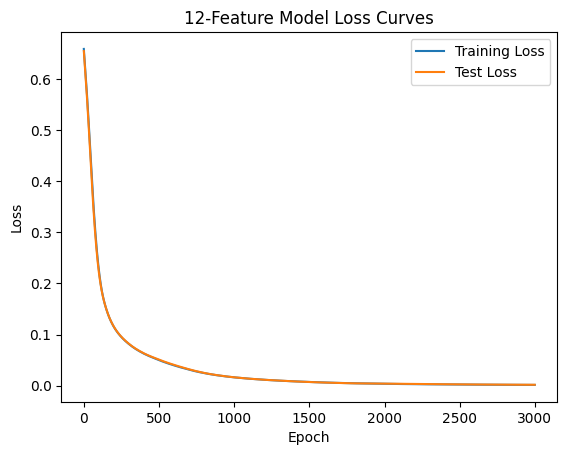

In [28]:
from alarmnetclass import AlarmNet
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = AlarmNet(
    num_features=X_train_raw.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_raw_device = torch.tensor(X_train_raw).float().to(device)
X_test_raw_device = torch.tensor(X_test_raw).float().to(device)
Y_train_raw_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_raw_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

full_model.train_model(
    epochs=3000,
    X_train=X_train_raw_device,
    X_test=X_test_raw_device,
    Y_train=Y_train_raw_device,
    Y_test=Y_test_raw_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 70000,
    print_epoch = 500
)
full_model.print_results()
full_model.plot_training("12-Feature Model Loss Curves")

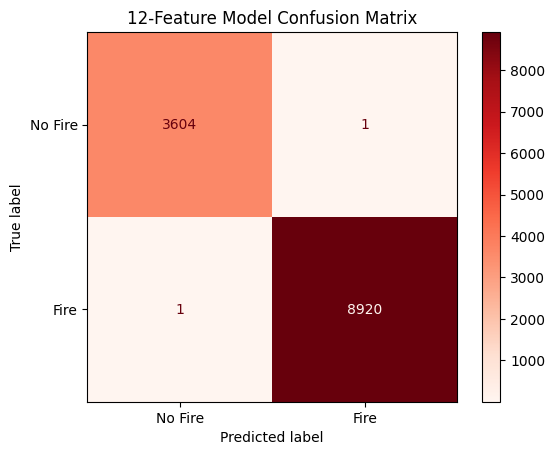

In [29]:
full_model.plot_confusion_matrix("12-Feature Model Confusion Matrix")

# Feature Analysis
- Initially there are 15 features
- 3 are unusable
    - UTC Timestamp
    - CNT
    - Unnamed: 0
- 12 features are usable

In [30]:
import numpy as np



corr = np.abs(data.corr())
ranking = corr['Fire Alarm'].sort_values(ascending=False)[1:]
print(ranking)

Humidity[%]       0.399846
Raw Ethanol       0.340652
Pressure[hPa]     0.249797
TVOC[ppb]         0.214743
Temperature[C]    0.163902
NC0.5             0.128118
PM1.0             0.110552
Raw H2            0.107007
eCO2[ppm]         0.097006
PM2.5             0.084916
NC1.0             0.082828
NC2.5             0.057707
Name: Fire Alarm, dtype: float64


In [31]:
num_drops = 8
remaining_features = ranking.index[:-num_drops]


X_df_dropped = data[remaining_features]
print('Remaining features:', X_df_dropped.columns)
X_train_dropped, X_test_dropped, Y_train_dropped, Y_test_dropped = train_test_split(X_df_dropped.values, Y_raw, test_size=0.2, random_state=0)

X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)


Remaining features: Index(['Humidity[%]', 'Raw Ethanol', 'Pressure[hPa]', 'TVOC[ppb]'], dtype='object')


Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.008275      |    6.764647e-08    |      0.718668      |      0.710502      |     -1.136395      |      4.001794      |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.003361      |    3.795359e-08    |      0.090793      |      0.093229      |      2.683426      |    

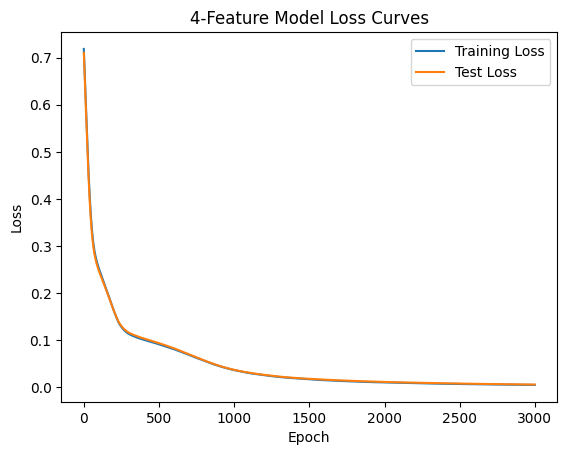

In [32]:
dropped_model = AlarmNet(
    num_features=X_train_dropped.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
    
).to(device)

X_train_dropped_device = torch.tensor(X_train_dropped).float().to(device)
X_test_dropped_device = torch.tensor(X_test_dropped).float().to(device)
Y_train_dropped_device = torch.tensor(Y_train_dropped).float().view(-1, 1).to(device)
Y_test_dropped_device = torch.tensor(Y_test_dropped).float().view(-1, 1).to(device)

dropped_model.train_model(
    epochs=3000,
    X_train=X_train_dropped_device,
    X_test=X_test_dropped_device,
    Y_train=Y_train_dropped_device,
    Y_test=Y_test_dropped_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 7000,
    print_epoch = 500
)
dropped_model.print_results()
AlarmNet.compare_results(dropped_model.get_results(), full_model.get_results())
dropped_model.plot_training("4-Feature Model Loss Curves")

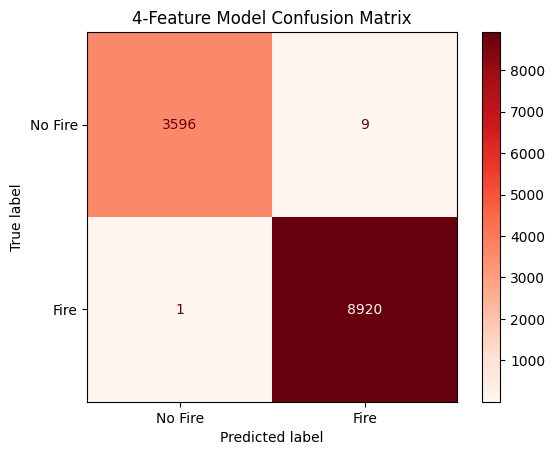

In [33]:
dropped_model.plot_confusion_matrix("4-Feature Model Confusion Matrix")

## Feature Analysis Results
- We can remove the bottom 8 features and have a model that only loses 0.1% precision, and even less for every other metric
- A 4 feature model is almost perfect
    - These features are:
        - Humidity
        - Raw Ethanol
        - Pressure
        - TVOC
- Note that the Particulate Matter sensor is not included in the 4-feature model.
    - To add redundancy to our model, we can add back the most correlated feature from the PM sensor
    - This feature is PM0.5




In [34]:

# Add back the most correlated PM feature, so that all 4 sensors are used
# PM0.5 is the most correlated PM feature, with index 5
remaining_features_2 = list(remaining_features)
remaining_features_2.append(ranking.index[5])
X_5f = data[remaining_features_2]
X_train_5f, X_test_5f, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)



scaler = StandardScaler()
X_train_5f_scaled = scaler.fit_transform(X_train_5f)
X_test_5f_scaled = scaler.transform(X_test_5f)

Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.006479      |    6.985440e-08    |      0.700277      |      0.693359      |     -0.987922      |     44.143033      |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.004610      |    4.857450e-08    |      0.100961      |      0.103135      |      2.153909      |    

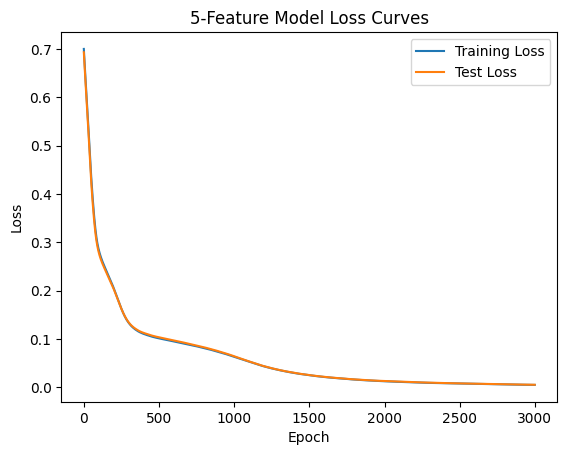

In [35]:

dropped_model_5 = AlarmNet(
    num_features=X_train_5f_scaled.shape[1],  # Update to match the new input dimensions
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)
epochs = 3000
alpha = 1e-2

X_train_5f_device = torch.tensor(X_train_5f_scaled).float().to(device)
X_test_5f_device = torch.tensor(X_test_5f_scaled).float().to(device)
Y_train_5f_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_5f_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

dropped_model_5.train_model(
    epochs=3000,
    X_train=X_train_5f_device,
    X_test=X_test_5f_device,
    Y_train=Y_train_5f_device,
    Y_test=Y_test_5f_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 7000,
    print_epoch = 500
)

dropped_model_5_results = dropped_model_5.get_results()
dropped_model_5.print_results()

AlarmNet.compare_results(dropped_model_5_results, dropped_model.get_results())

dropped_model_5.plot_training("5-Feature Model Loss Curves")


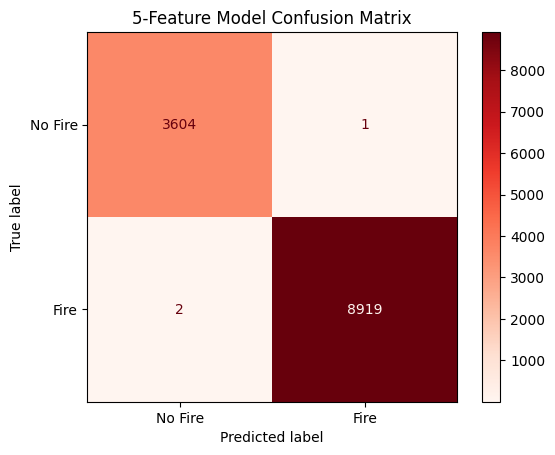

In [36]:
dropped_model_5.plot_confusion_matrix("5-Feature Model Confusion Matrix")

# Outlier Removal
- The curve above has an odd spike in the middle of training. This may be due to the heavily biased distributions of the NC0.5 and TVOC features

array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

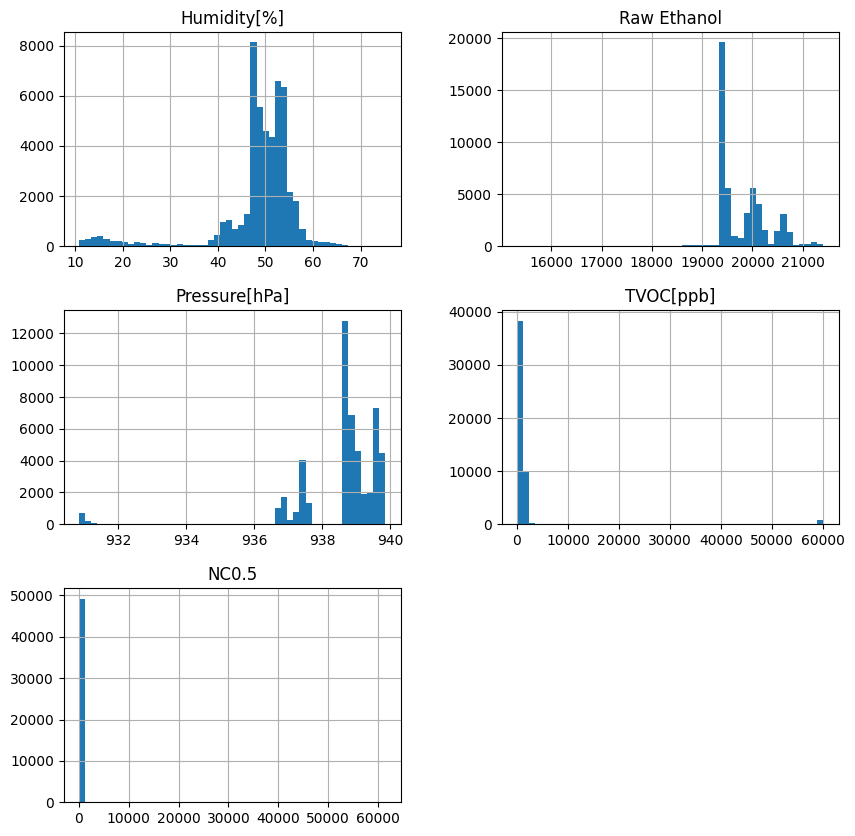

In [37]:
#X_train_5f_scaled, X_test_5f_scaled, Y_train_5f, Y_test_5f = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_5f.hist(
    figsize=(10, 10),
    bins=50
    )

## Outlier Removal
- The majority of the data in the NC0.5 feature lies below 30, and the majority of the data in the TVOC feature lies below 1500
- By removing the data above these thresholds, we can remove the bias from the data and produce a much more even distribution
- However, this filter cannot be applied to the validation data, as the real sensor data will likely follow the original skewed distribution

Data reduction: 5.79%


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

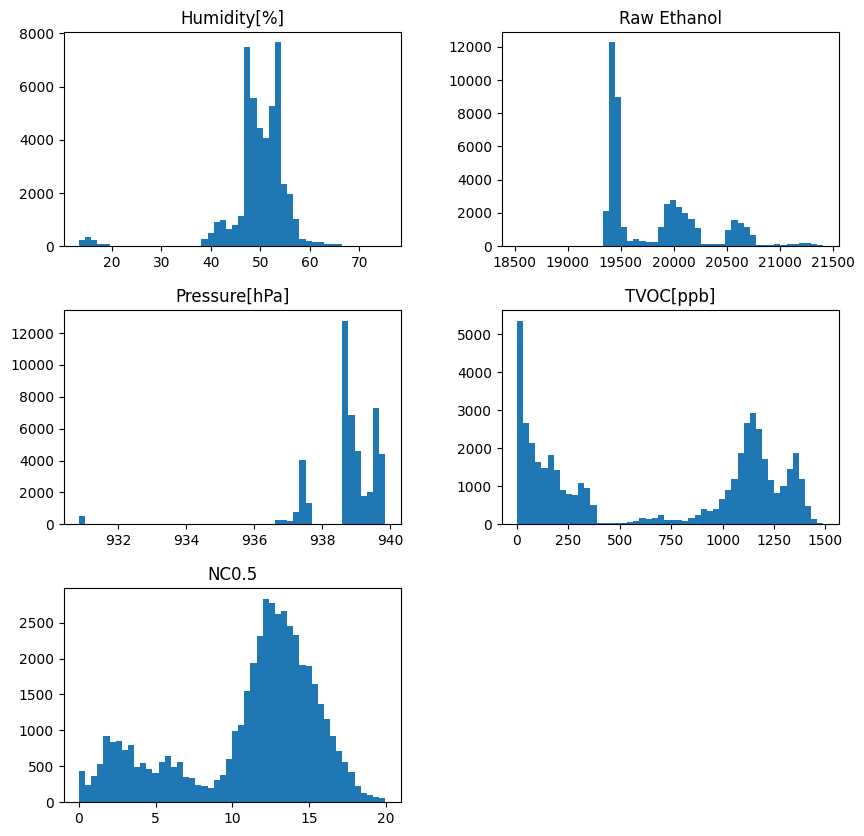

In [38]:
import matplotlib.pyplot as plt

TVOC_threshold = 1500
NC0_5_threshold = 20

X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_5f, Y_df, test_size=0.2, random_state=0)

X_train_outlier =  X_train_outlier[(X_train_outlier['TVOC[ppb]'] < TVOC_threshold) & (X_train_outlier['NC0.5'] < NC0_5_threshold)]
Y_train_outlier = Y_train_outlier[X_train_outlier.index]

data_reduction = 100*(1 - X_train_outlier.shape[0] / X_train_5f_scaled.shape[0])
print(f'Data reduction: {data_reduction:.2f}%')

X_train_outlier.hist(
    figsize=(10, 10),
    grid=False,
    bins=50
)

## Improved Distribution
- The training data is much more evenly distributed.
- However, it does not make sense to apply this filter to the validation data, as the real sensor values will follow the original distribution

In [39]:
#remove all rows where TVOC>3000 or NC0.5>4000

scaler = StandardScaler()
scaler.fit(X_train_5f)
X_train_outlier_scaled = scaler.transform(X_train_outlier)
X_test_outlier_scaled = scaler.transform(X_test_5f)


X_train_outlier_device = torch.tensor(X_train_outlier_scaled).float().to(device)
X_test_outlier_device = torch.tensor(X_test_outlier_scaled).float().to(device)
Y_train_outlier_device = torch.tensor(Y_train_outlier.values).float().view(-1, 1).to(device)
Y_test_outlier_device = torch.tensor(Y_test_5f.values).float().view(-1, 1).to(device)

outlier_model = AlarmNet(
    num_features=X_train_outlier.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 128, 64]
).to(device)

outlier_model.train_model(
    epochs=4000,
    X_train=X_train_outlier_device,
    X_test=X_test_outlier_device,
    Y_train=Y_train_outlier_device,
    Y_test=Y_test_outlier_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-4},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 7000,
    print_epoch = 500
)
outlier_model.print_results()
AlarmNet.compare_results(outlier_model.get_results(), dropped_model_5_results)
outlier_model.plot_training("Outlier Removal Model Loss Curves")


Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.017097      |    5.129635e-08    |      0.717102      |      0.714682      |     -0.337429      |      0.201771      |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.005715      |    6.041359e-08    |      0.208020      |      0.743790      |     257.556244     |    

# Imputation
- The training and validation datasets have completely different distributions
    - This causes overfitting
- Solution: Imputation
    - Replace each value above the threshold with the median of the feature
    - Chose median because it is a better measure of center than mean for skewed distributions


In [14]:
class Imputer:
    def __init__(self, thresholds: list[float]):
        self.thresholds = thresholds
    def fit(self, data: pd.DataFrame):
        self.replacements = data.median()

    def transform(self, data: pd.DataFrame, transform_all=True) -> pd.DataFrame:
        for i, column in enumerate(data.columns):
            if transform_all:
                data[column] = data[column].apply(lambda x: self.replacements.iloc[i] if ( not (self.thresholds[i][0] < x < self.thresholds[i][1]) or np.isnan(x)) else x)
            else:
                data[column] = data[column].apply(lambda x: self.replacements.iloc[i] if np.isnan(x) else x)
        return data
    def fit_transform(self, data: pd.DataFrame, transform_all = True) -> pd.DataFrame:
        self.fit(data)
        return self.transform(data, transform_all=transform_all)

(50104, 5)


array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

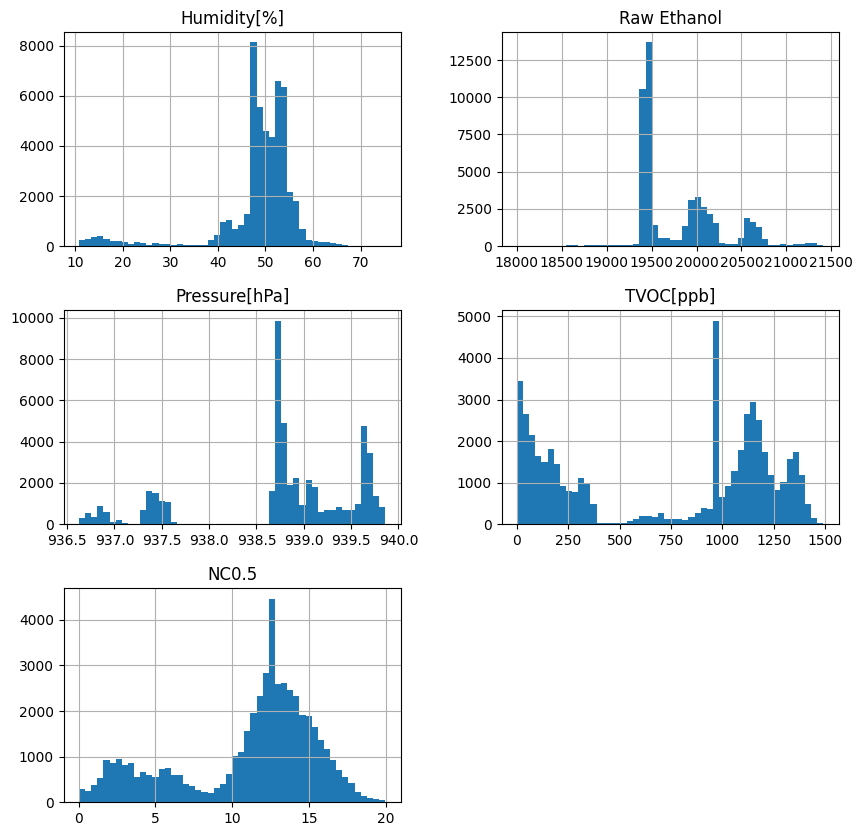

In [15]:
X_train_imputed, X_test_imputed, Y_train_imputed, Y_test_imputed = train_test_split(X_5f, Y_df.values, test_size=0.2, random_state=0)

thresholds = [(0,70000), (18000, 70000), (936, 70000), (0, 1500), (0,20)]
#thresholds = [(0,70000), (0, 70000), (0, 70000), (0, 2500), (0,400)]
imputer = Imputer(thresholds)

X_train_imputed = imputer.fit_transform(X_train_imputed)
X_test_imputed = imputer.transform(X_test_imputed)

print(X_train_imputed.shape)
X_train_imputed.hist(
    figsize=(10, 10),
    bins=50
)
# print(X_train_5f.shape)
# print(X_train_imputed.shape)
# print(Y_train_imputed.shape)

Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.007791      |    3.563145e-08    |      0.690920      |      0.685385      |     -0.801098      |     100.000000     |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.003024      |    3.511754e-08    |      0.014535      |      0.017390      |     19.646303      |    

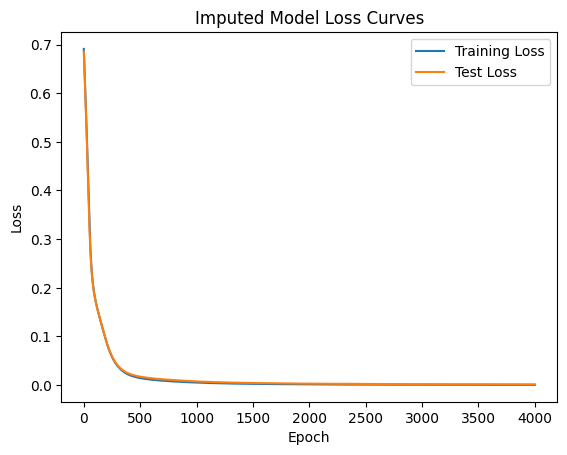

In [16]:

X_train_imputed_device = torch.tensor(scaler.fit_transform(X_train_imputed)).float().to(device)
X_test_imputed_device = torch.tensor(scaler.transform(X_test_imputed)).float().to(device)
Y_train_imputed_device = torch.tensor(Y_train_imputed).float().view(-1, 1).to(device)
Y_test_imputed_device = torch.tensor(Y_test_imputed).float().view(-1, 1).to(device)

imputed_model = AlarmNet(
    num_features=X_train_imputed.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
).to(device)

imputed_model.train_model(
    epochs=4000,
    X_train=X_train_imputed_device,
    X_test=X_test_imputed_device,
    Y_train=Y_train_imputed_device,
    Y_test=Y_test_imputed_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-3},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 7000,
    print_epoch = 500
)

imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5_results)
imputed_model.plot_training("Imputed Model Loss Curves")


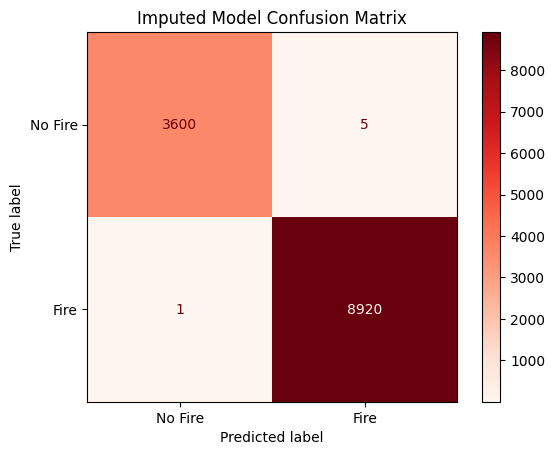

In [17]:
imputed_model.plot_confusion_matrix("Imputed Model Confusion Matrix")


# Error Handling
- The 12 initial features came from 4 sensors
    - Temp/Humidity
    - Pressure
    - Volatile Organic Compounds (CO2, Ethanol, H2, TVOC)
    - Particulate Matter (PM1, PM2.5, NC0.5, NC1, NC2.5)
- 3 of these sensors are redundant, with the exception being the PM sensor
    - This means that the features related to the PM sensor are twice as likely to be missing
- We can simulate a real world scenario by introducing error according to this distribution

In [21]:
import random

# Introduce sensor errors 

def insert_errors(data: pd.DataFrame, error_chances=list[float]):

    VOC_features = [
        'TVOC[ppb]',
        'eCO2[ppm]',
        'Raw H2',
        'Raw Ethanol'
    ]

    PM_features = [
        'PM1.0',
        'PM2.5',
        'NC0.5',
        'NC1.0',
        'NC2.5'
    ]

    th_features = [
        'Temperature[C]',
        'Humidity[%]'
    ]
    pressure_features = [
        'Pressure[hPa]'
    ]

    # The PM sensor is twice as likely to fail due to lack of redundancy
    sensors = [VOC_features, PM_features, th_features, pressure_features]

    data_new = data.copy(deep=True).values
    for i, datapoint in enumerate(data_new):
        errored_features = []
        for j, sensor in enumerate(sensors):
            sensor_error = random.random() < error_chances[j]
            if sensor_error:
                errored_features.extend(sensor)
        errored_features = [feature for feature in errored_features if feature in data.columns]
        if errored_features:
            for feature in errored_features:
                data_new[i][data.columns.get_loc(feature)] = np.nan
            # print(i, X_error_np[i])
    return data_new

error_chance =0.2
chances = [error_chance, error_chance*2, error_chance, error_chance]

X_error = insert_errors(X_5f, chances)

X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error, Y_df.values, test_size=0.2, random_state=0)

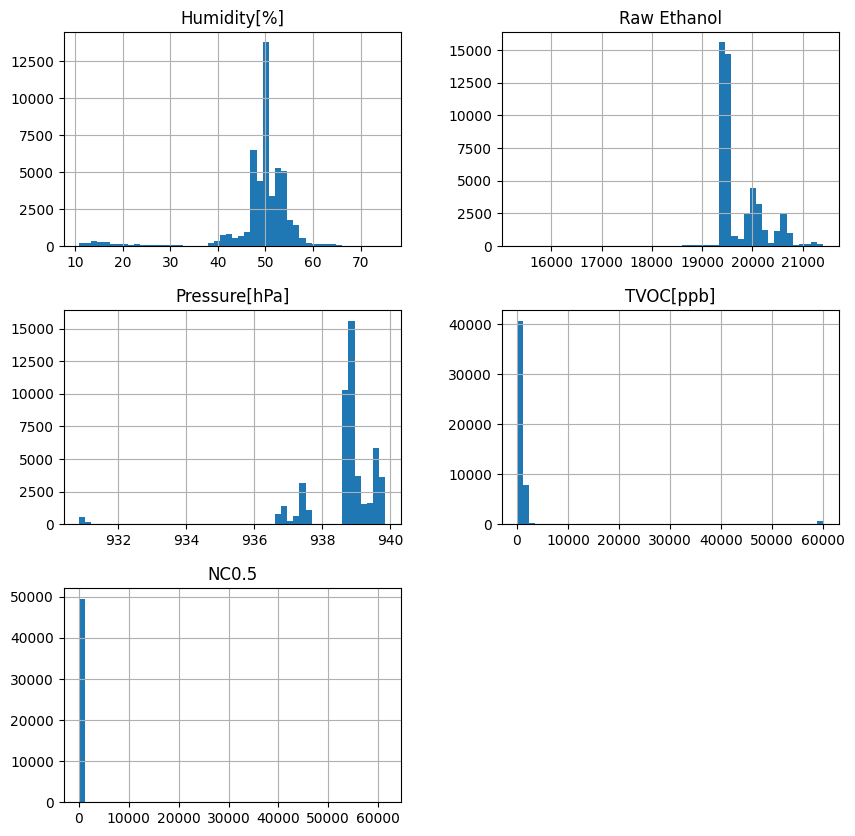

In [22]:
imputer_2 = Imputer(thresholds)
X_train_error_imputed = imputer_2.fit_transform(pd.DataFrame(X_train_error, columns=X_5f.columns), transform_all=False)
X_test_error_imputed = imputer_2.transform(pd.DataFrame(X_test_error, columns=X_5f.columns), transform_all=False)
X_train_error_imputed.hist(
    figsize=(10, 10),
    bins=50
)  
scaler = StandardScaler()
X_train_error_scaled = scaler.fit_transform(X_train_error_imputed)
X_test_error_scaled = scaler.transform(X_test_error_imputed)

In [23]:
measurement_count = X_error.shape[0]*X_error.shape[1]
error_count = np.count_nonzero(np.isnan(X_error))
error_rate = error_count / measurement_count
print(f"Measurement Count: {measurement_count}")
print(f"Error Count: {error_count}")
print(f'Error rate: {error_rate:.2f}')

Measurement Count: 313150
Error Count: 75993
Error rate: 0.24


Training AlarmNet

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|       Epoch        |   Epoch Time (s)   | Inf Time (s/samp)  |   Training Loss    |     Test Loss      |    Overfit (%)     |     Recall (%)     |    Δ Recall (%)    |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      0.313677      |    4.663114e-07    |      0.675204      |      0.675114      |     -0.013303      |     100.000000     |      0.000000      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|        500         |      0.006211      |    4.010442e-08    |      0.444153      |      0.439994      |     -0.936397      |    

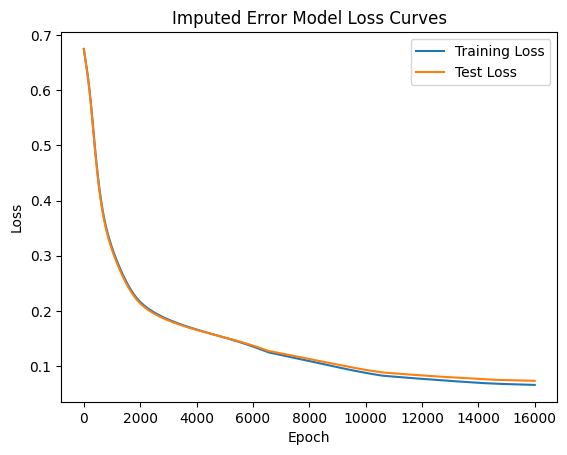

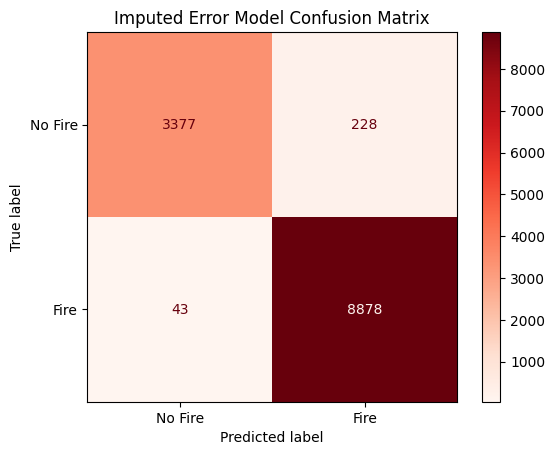

In [24]:
from alarmnetclass import AlarmNet
import torch
from torch import nn


imputed_error_model = AlarmNet(
    num_features=5,
    activation = nn.ReLU,
    hidden_layers=[256, 256, 256]
).to(device)

X_train_error_device = torch.tensor(X_train_error_scaled).float().to(device)
X_test_error_device = torch.tensor(X_test_error_scaled).float().to(device)
Y_train_error_device = torch.tensor(Y_train_error).float().view(-1, 1).to(device)
Y_test_error_device = torch.tensor(Y_test_error).float().view(-1, 1).to(device)

imputed_error_model.train_model(
    epochs=16000,
    X_train=X_train_error_device,
    X_test=X_test_error_device,
    Y_train=Y_train_error_device,
    Y_test=Y_test_error_device,
    optimizer = torch.optim.Adam,
    optimizer_kwargs={'lr': 1e-5},
    scheduler_kwargs={'factor': 0.5, 'patience': 4000, 'threshold': 1e-3},
    header_epoch = 70000,
    print_epoch = 500
)

imputed_error_model.print_results()
AlarmNet.compare_results(imputed_error_model.get_results(), dropped_model_5.get_results())
imputed_error_model.plot_training("Imputed Error Model Loss Curves")
imputed_error_model.plot_confusion_matrix("Imputed Error Model Confusion Matrix")


In [25]:
model_count = sum(p.numel() for p in imputed_error_model.parameters())
model_size = sum(p.numel() * p.element_size() for p in imputed_error_model.parameters())
print(f'param_count: {model_count}')
print(f'Model Size: {model_count/1024:.2f} KB')

impute_cpu = imputed_error_model.to('cpu')

start = time.time()
impute_cpu(X_test_error_device.to('cpu'))
end = time.time()
eval_time = (end-start)/X_test_error_device.shape[0]
print(f'Inference Time Per Sample: {end-start:.2e} s')


param_count: 133377
Model Size: 130.25 KB
Inference Time: 5.10e-02 s


# Conclusion
- The error generation removed 24% of the data
- Yet, through imputation, only 0.6% more houses burned down
    - Recall decreased by 0.6% between the original and imputed datasets

In [26]:
end = time.time()
print(f'Time elapsed: {end-start:.2f} seconds')

Time elapsed: 0.09 seconds
